In [1]:
#Package
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train=pd.read_csv("merged_train.csv")
test=pd.read_csv("merged_test.csv")

In [3]:
# merged_ data에서 drop해야 할 단지코드
print(train.shape, test.shape)
train = train.loc[~train.단지코드.isin(['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']),]
test = test.loc[~test.단지코드.isin(['C2335', 'C1327', 'C2675'])]
print(train.shape, test.shape)

(2952, 34) (1022, 33)
(2896, 34) (1008, 33)


In [4]:
print(len(set(train.단지코드)), len(set(test.단지코드)))

414 147


In [5]:
print(train.shape, test.shape)

(2896, 34) (1008, 33)


In [6]:
train[train.단지코드=="C2085"][["단지코드","총세대수","단지내주차면수","공가수"]]

,단지코드,총세대수,단지내주차면수,공가수
1481,C2085,370,1590.0,9.0
1482,C2085,370,1590.0,9.0
1483,C2085,370,1590.0,9.0
1484,C2085,370,1590.0,9.0
1485,C2085,370,1590.0,9.0
1486,C2085,370,1590.0,9.0
1624,C2085,969,1590.0,0.0
1625,C2085,969,1590.0,0.0
1626,C2085,969,1590.0,0.0
1627,C2085,969,1590.0,0.0


In [7]:
train.at[range(1481,1487),"총세대수"]=1339
train.at[range(1624,1632),"총세대수"]=1339
train.at[range(1481,1487),"공가수"]=9
train.at[range(1624,1632),"공가수"]=9

In [8]:
train[train.단지코드=="C1649"][["단지코드","총세대수","단지내주차면수","공가수","등록차량수", "버스정류장","지하철역"]]

,단지코드,총세대수,단지내주차면수,공가수,등록차량수,버스정류장,지하철역
1753,C1649,575,1066.0,15.0,855.0,4.0,0.0
1754,C1649,575,1066.0,15.0,855.0,4.0,0.0
1755,C1649,575,1066.0,15.0,855.0,4.0,0.0
1756,C1649,575,1066.0,15.0,855.0,4.0,0.0
1810,C1649,472,1066.0,16.0,359.0,2.0,0.0
1811,C1649,472,1066.0,16.0,359.0,2.0,0.0


In [9]:
train.at[range(1753,1757),"총세대수"]=1047
train.at[range(1810,1812),"총세대수"]=1047
train.at[range(1753,1757),"공가수"]=31
train.at[range(1810,1812),"공가수"]=31
train.at[range(1753,1757),"등록차량수"]=1214
train.at[range(1810,1812),"등록차량수"]=1214
train.at[range(1753,1757),"버스정류장"]=4
train.at[range(1810,1812),"버스정류장"]=4

In [10]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

## 상가비율, 대형전용면적, 세대당가능주차면수, 공가수, 분양세대수

In [11]:
print("\n...Before preprocessing")
print(train.shape, test.shape)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 세대당_가능주차면수 column 추기
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# 분양세대수 column 추가
train_sale = pd.DataFrame(train.groupby(['단지코드']).first()['총세대수'] - train.groupby(['단지코드']).sum()['전용면적별세대수'])
train_sale.columns = ["분양세대수"]
train_sale = train_sale.astype('int16')
train_sale.reset_index(inplace=True)
train = pd.merge(train, train_sale,on="단지코드")

test_sale = pd.DataFrame(test.groupby(['단지코드']).first()['총세대수'] - test.groupby(['단지코드']).sum()['전용면적별세대수'])
test_sale.columns = ["분양세대수"]
test_sale = test_sale.astype('int16')
test_sale.reset_index(inplace=True)
test = pd.merge(test, test_sale,on="단지코드")

# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 34) (936, 33)

...After preprocessing
(2577, 39) (936, 38)


# 자격유형

In [12]:
dic = {'1': 'A' ,'2':['C','F','G'],'3':['B','H','I'],'4':['J'],
       '5':['L',"M","N","O"],'6':["E","K"],'7':'D'}

In [13]:
def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

In [14]:
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)
train= train.drop(columns="자격유형")
test= test.drop(columns="자격유형")

# 공급유형

In [15]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [16]:
train.shape, test.shape

((2577, 39), (936, 38))

# 임대료, 임대보증금을 시세와 비슷하게 만들 수 없을까?

In [17]:
pd.concat([pd.DataFrame(train.공급유형.value_counts()), 
           pd.DataFrame(test.공급유형.value_counts())],axis=1)

,공급유형,공급유형
국민임대,1708,611.0
임대상가,286,112.0
행복주택,192,118.0
공공임대(단기),183,34.0
영구임대,149,42.0
공공임대(50년),31,13.0
공공임대(분납),12,6.0
장기전세,9,NaN
공공분양,7,NaN


In [18]:
pd.concat([pd.DataFrame(round(train.groupby(['공급유형']).mean()['임대료']).reset_index()),
          pd.DataFrame(round(train.groupby(['공급유형']).mean()['임대보증금']).reset_index())], 
          axis=1)

,공급유형,임대료,공급유형,임대보증금
0,공공분양,506087.0,공공분양,74501440.0
1,공공임대(50년),201580.0,공공임대(50년),13954581.0
2,공공임대(단기),515103.0,공공임대(단기),50100978.0
3,공공임대(분납),288817.0,공공임대(분납),116959500.0
4,국민임대,172773.0,국민임대,23372528.0
5,영구임대,93658.0,영구임대,8583733.0
6,임대상가,3633128.0,임대상가,12715418.0
7,장기전세,0.0,장기전세,184243000.0
8,행복주택,124890.0,행복주택,34636375.0


- 국민임대 임대료: 시중시세의 60~80퍼센트
- 공공임대(5년, 10년, 50년) 임대료: 시세대비 60~90% or 시중시세 이하
- 영구임대 임대료: 시세대비 30% 수준
- 행복주택 임대료: 시중시세의 60~80퍼센트

=> 영구임대만 임대료/임대보증금을 2배로 해보자. 

In [19]:
train.공급유형.unique()

array(['국민임대', '공공임대(50년)', '영구임대', '임대상가', '공공임대(단기)', '공공임대(분납)',
       '장기전세', '공공분양', '행복주택'], dtype=object)

In [20]:
train.loc[train.공급유형=="영구임대", "임대료"].head()

71    130850.0
72    144460.0
81     69900.0
82     69900.0
83     83020.0
Name: 임대료, dtype: float64

In [21]:
train.loc[train.공급유형=="영구임대", "임대료"]=train.loc[train.공급유형=="영구임대", "임대료"]*2

In [22]:
train.loc[train.공급유형=="영구임대", "임대료"].head()

71    261700.0
72    288920.0
81    139800.0
82    139800.0
83    166040.0
Name: 임대료, dtype: float64

In [23]:
train.loc[train.공급유형=="영구임대", "임대보증금"]

71       8052000.0
72       9174000.0
81       3141000.0
82       3141000.0
83       3731000.0
           ...    
2393     8184000.0
2394     8184000.0
2535    13126000.0
2536    13164000.0
2570    10346000.0
Name: 임대보증금, Length: 149, dtype: float64

In [24]:
train.loc[train.공급유형=="영구임대", "임대보증금"]=train.loc[train.공급유형=="영구임대", "임대보증금"]*2

In [25]:
test.loc[test.공급유형=="영구임대", "임대료"]=test.loc[test.공급유형=="영구임대", "임대료"]*2

In [26]:
test.loc[test.공급유형=="영구임대", "임대보증금"]=test.loc[test.공급유형=="영구임대", "임대보증금"]*2

# 어제 결과를 보니까 1차원으로 해야 할 것 같다.

In [27]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명', '도로명주소',
       '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수', '총인구수',
       '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상',
       '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수',
       '공가수비율', '대형전용면적', '분양세대수', '자격유형_카테고리'],
      dtype='object')

In [28]:
len(set(train.단지코드))

414

In [29]:
data = train.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
data = data.drop_duplicates()

In [30]:
data.shape

(414, 31)

In [31]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()

In [32]:
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1000,국민임대,566
1,C1004,영구임대,504
2,C1004,임대상가,13
3,C1005,국민임대,1144
4,C1013,국민임대,1308


In [33]:
for i in sample.공급유형.unique():
    data[str(i)]=0

In [34]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [35]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1000,121064.285714,1.320357e+07
1,C1004,891923.520581,1.101129e+07
2,C1005,222046.666667,1.710767e+07
3,C1013,134726.000000,2.492480e+07
4,C1014,160488.571429,2.389400e+07


In [36]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = data[data['단지코드']==code].index
    data.loc[ind,'임대료'] = val1
    data.loc[ind,'임대보증금'] = val2

In [37]:
sample = pd.DataFrame(train.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1000,1,566
1,C1004,2,504
2,C1004,7,13
3,C1005,1,1144
4,C1013,1,1308


In [38]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [39]:
data=data.fillna(0)

In [40]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1000,0
1,C1004,1
2,C1005,0
3,C1013,0
4,C1014,0


In [41]:
data=pd.merge(data, sample, on="단지코드", how="inner")

In [42]:
sample1=pd.DataFrame(train.groupby("단지코드")["전용면적"].mean()).reset_index()
sample2=pd.DataFrame(train.groupby("단지코드")["전용면적별세대수"].mean()).reset_index()
data=pd.merge(data, sample1, on="단지코드", how="inner")
data=pd.merge(data, sample2, on="단지코드", how="inner")
data.head()

,단지코드,총세대수,지역,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,단지명,도로명주소,...,1,2,7,3,6,4,5,대형전용면적,전용면적,전용면적별세대수
0,C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,미수휴먼시아,경상남도 통영시 미우지해안로 107,...,545.0,0.0,0.0,0.0,0.0,0.0,0.0,0,44.345714,77.857143
1,C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,도안 휴먼시아 4단지,대전광역시 유성구 상대로 40,...,914.0,0.0,0.0,0.0,0.0,0.0,0.0,0,39.326250,114.250000
2,C1945,755,경기도,6.0,1.0,3.0,734.0,730.0,호평마을 주공휴먼시아,경기도 남양주시 늘을3로 8,...,0.0,0.0,0.0,635.0,0.0,0.0,0.0,0,52.668000,127.000000
3,C1470,696,전라북도,14.0,0.0,2.0,645.0,553.0,장신휴먼시아1단지,전라북도 익산시 오산면 선화로4길 66,...,696.0,0.0,0.0,0.0,0.0,0.0,0.0,0,42.982500,174.000000
4,C1898,566,전라북도,9.0,0.0,6.0,517.0,415.0,장신휴먼시아2단지,전라북도 익산시 오산면 선화로4길 24-9,...,566.0,0.0,0.0,0.0,0.0,0.0,0.0,0,42.575000,94.333333


In [43]:
sample1=pd.DataFrame(train.groupby("단지코드")["임대료"].std()).reset_index()
sample2=pd.DataFrame(train.groupby("단지코드")["임대보증금"].std()).reset_index()
data=pd.merge(data, sample1, on="단지코드", how="inner")
data=pd.merge(data, sample2, on="단지코드", how="inner")
data.head()

,단지코드,총세대수,지역,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,단지명,도로명주소,...,7,3,6,4,5,대형전용면적,전용면적,전용면적별세대수,임대료_y,임대보증금_y
0,C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,미수휴먼시아,경상남도 통영시 미우지해안로 107,...,0.0,0.0,0.0,0.0,0.0,0,44.345714,77.857143,42079.044553,5.398382e+06
1,C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,도안 휴먼시아 4단지,대전광역시 유성구 상대로 40,...,0.0,0.0,0.0,0.0,0.0,0,39.326250,114.250000,43403.524194,9.928516e+06
2,C1945,755,경기도,6.0,1.0,3.0,734.0,730.0,호평마을 주공휴먼시아,경기도 남양주시 늘을3로 8,...,0.0,635.0,0.0,0.0,0.0,0,52.668000,127.000000,47045.761021,5.616362e+06
3,C1470,696,전라북도,14.0,0.0,2.0,645.0,553.0,장신휴먼시아1단지,전라북도 익산시 오산면 선화로4길 66,...,0.0,0.0,0.0,0.0,0.0,0,42.982500,174.000000,21378.507899,6.753065e+06
4,C1898,566,전라북도,9.0,0.0,6.0,517.0,415.0,장신휴먼시아2단지,전라북도 익산시 오산면 선화로4길 24-9,...,0.0,0.0,0.0,0.0,0.0,0,42.575000,94.333333,19152.348594,6.067941e+06


In [44]:
sample1=pd.DataFrame(train.groupby("단지코드")["전용면적"].std()).reset_index()
sample2=pd.DataFrame(train.groupby("단지코드")["전용면적별세대수"].std()).reset_index()
data=pd.merge(data, sample1, on="단지코드", how="inner")
data=pd.merge(data, sample2, on="단지코드", how="inner")
data.head(3)

,단지코드,총세대수,지역,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,단지명,도로명주소,...,6,4,5,대형전용면적,전용면적_x,전용면적별세대수_x,임대료_y,임대보증금_y,전용면적_y,전용면적별세대수_y
0,C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,미수휴먼시아,경상남도 통영시 미우지해안로 107,...,0.0,0.0,0.0,0,44.345714,77.857143,42079.044553,5.398382e+06,6.981112,92.611066
1,C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,도안 휴먼시아 4단지,대전광역시 유성구 상대로 40,...,0.0,0.0,0.0,0,39.326250,114.250000,43403.524194,9.928516e+06,7.681880,83.941731
2,C1945,755,경기도,6.0,1.0,3.0,734.0,730.0,호평마을 주공휴먼시아,경기도 남양주시 늘을3로 8,...,0.0,0.0,0.0,0,52.668000,127.000000,47045.761021,5.616362e+06,8.257813,59.422218


# Test에 똑같이

In [45]:
print(len(set(test.단지코드)))
dat = test.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
dat = dat.drop_duplicates()
dat.shape

147


(147, 30)

In [46]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1003,행복주택,480
1,C1006,영구임대,1475
2,C1006,임대상가,13
3,C1016,국민임대,643
4,C1019,국민임대,321


In [47]:
for i in sample.공급유형.unique():
    dat[str(i)]=0

In [48]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [49]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1003,1.158750e+05,2.265000e+07
1,C1006,2.363425e+06,1.973874e+07
2,C1016,2.280100e+05,2.402675e+07
3,C1019,1.264300e+05,1.485750e+07
4,C1030,2.142167e+05,5.141333e+07


In [50]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,'임대료'] = val1
    dat.loc[ind,'임대보증금'] = val2

In [51]:
sample = pd.DataFrame(test.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1003,4,480
1,C1006,2,1459
2,C1006,7,29
3,C1016,1,643
4,C1019,1,321


In [52]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [53]:
dat=dat.fillna(0)

In [54]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1003,0
1,C1006,1
2,C1016,0
3,C1019,0
4,C1030,0


In [55]:
dat=pd.merge(dat, sample, on="단지코드", how="inner")

In [56]:
sample1=pd.DataFrame(test.groupby("단지코드")["전용면적"].mean()).reset_index()
sample2=pd.DataFrame(test.groupby("단지코드")["전용면적별세대수"].mean()).reset_index()
dat=pd.merge(dat, sample1, on="단지코드", how="inner")
dat=pd.merge(dat, sample2, on="단지코드", how="inner")

sample1=pd.DataFrame(test.groupby("단지코드")["임대료"].std()).reset_index()
sample2=pd.DataFrame(test.groupby("단지코드")["임대보증금"].std()).reset_index()
dat=pd.merge(dat, sample1, on="단지코드", how="inner")
dat=pd.merge(dat, sample2, on="단지코드", how="inner")

sample1=pd.DataFrame(test.groupby("단지코드")["전용면적"].std()).reset_index()
sample2=pd.DataFrame(test.groupby("단지코드")["전용면적별세대수"].std()).reset_index()
dat=pd.merge(dat, sample1, on="단지코드", how="inner")
dat=pd.merge(dat, sample2, on="단지코드", how="inner")
dat.head()

,단지코드,총세대수,지역,공가수,지하철역,버스정류장,단지내주차면수,단지명,도로명주소,연면적,...,6,3,5,대형전용면적,전용면적_x,전용면적별세대수_x,임대료_y,임대보증금_y,전용면적_y,전용면적별세대수_y
0,C1072,754,경기도,14,0.0,2,683,광명역세권 휴먼시아2단지,경기도 광명시 서원로 25,13.320,...,0.0,724.0,0.0,0,48.436250,94.250000,38479.156858,7.194365e+06,4.256366,53.625021
1,C1128,1354,경기도,9,0.0,3,1216,광명역세권 휴먼시아1단지,경기도 광명시 성채안로 26,3773.770,...,0.0,1132.0,0.0,0,46.178889,150.444444,46424.527731,9.064546e+06,5.259844,148.002628
2,C1456,619,부산광역시,18,0.0,16,547,안락휴먼시아,부산광역시 동래구 충렬대로447번길 38,6035.780,...,0.0,0.0,0.0,0,44.771250,66.625000,49650.253344,1.147678e+07,8.432601,43.457492
3,C1840,593,전라북도,7,0.0,3,543,장신휴먼시아3단지,전라북도 익산시 오산면 선화로4길 14,6006.870,...,0.0,0.0,0.0,0,44.492500,148.250000,18024.444513,5.407500e+06,6.043577,81.960865
4,C1332,1297,경기도,11,0.0,2,1112,봇들마을 6단지,경기도 성남시 분당구 동판교로 212,361.789,...,0.0,1297.0,0.0,0,46.453750,162.125000,61330.117980,8.676170e+06,4.543887,69.800609


In [58]:
data.columns

Index([       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',       '등록차량수',
               '단지명',       '도로명주소',         '연면적',          '위도',
                '경도', 'subway_name', 'subway_dist',       '환승역 수',
              '총인구수',      '세대당_인구',       '남/여비율',   '남/여_0~19세',
        '남/여_20~39세',  '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',
         '20~39세_비율',   '40~69세_비율',    '70세이상_비율',        '상가비율',
        '세대당_가능주차면수',       '공가수비율',       '분양세대수',        '국민임대',
              '영구임대',        '임대상가',    '공공임대(단기)',        '장기전세',
              '행복주택',    '공공임대(분납)',        '공공분양',   '공공임대(50년)',
             '임대료_x',     '임대보증금_x',             1,             2,
                   7,             3,             6,             4,
                   5,      '대형전용면적',      '전용면적_x',  '전용면적별세대수_x',
             '임대료_y',     '임대보증금_y',      '전용면적_y',  '전용면적별세대수_y'],
      dtype='object')

In [59]:
dat.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',         '단지명',
             '도로명주소',         '연면적',          '위도',          '경도',
       'subway_name', 'subway_dist',       '환승역 수',        '총인구수',
            '세대당_인구',       '남/여비율',   '남/여_0~19세',  '남/여_20~39세',
        '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',   '20~39세_비율',
         '40~69세_비율',    '70세이상_비율',        '상가비율',  '세대당_가능주차면수',
             '공가수비율',       '분양세대수',        '행복주택',        '영구임대',
              '임대상가',        '국민임대',   '공공임대(50년)',    '공공임대(단기)',
          '공공임대(분납)',       '임대료_mean',     '임대보증금_mean',            '자격유형4',
                   '자격유형2',          '자격유형7',  '자격유형1'  ,             '자격유형6',
                   '자격유형3',           '자격유형5' ,      '대형전용면적',      '전용면적_mean',
        '전용면적별세대수_mean',       '임대료_std',     '임대보증금_std',      '전용면적_std',
        '전용면적별세대수_std']
data.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',       '등록차량수',
               '단지명',       '도로명주소',         '연면적',          '위도',
                '경도', 'subway_name', 'subway_dist',       '환승역 수',
              '총인구수',      '세대당_인구',       '남/여비율',   '남/여_0~19세',
        '남/여_20~39세',  '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',
         '20~39세_비율',   '40~69세_비율',    '70세이상_비율',        '상가비율',
        '세대당_가능주차면수',       '공가수비율',       '분양세대수',        '국민임대',
              '영구임대',        '임대상가',    '공공임대(단기)',        '장기전세',
              '행복주택',    '공공임대(분납)',        '공공분양',   '공공임대(50년)',
             '임대료_mean',     '임대보증금_mean',       '자격유형1',   '자격유형2',
               '자격유형7' ,          '자격유형3' ,       '자격유형6' ,        '자격유형4' ,
                  '자격유형5' ,      '대형전용면적',      '전용면적_mean',  '전용면적별세대수_mean',
             '임대료_std',     '임대보증금_std',      '전용면적_std',  '전용면적별세대수_std']

In [80]:
data=data.fillna(0)

# Correlation 확인

In [60]:
X_cor = data.drop(columns=['단지코드','단지명','도로명주소','subway_name', "지역"])

In [61]:
X_cor = pd.get_dummies(X_cor, drop_first=True)

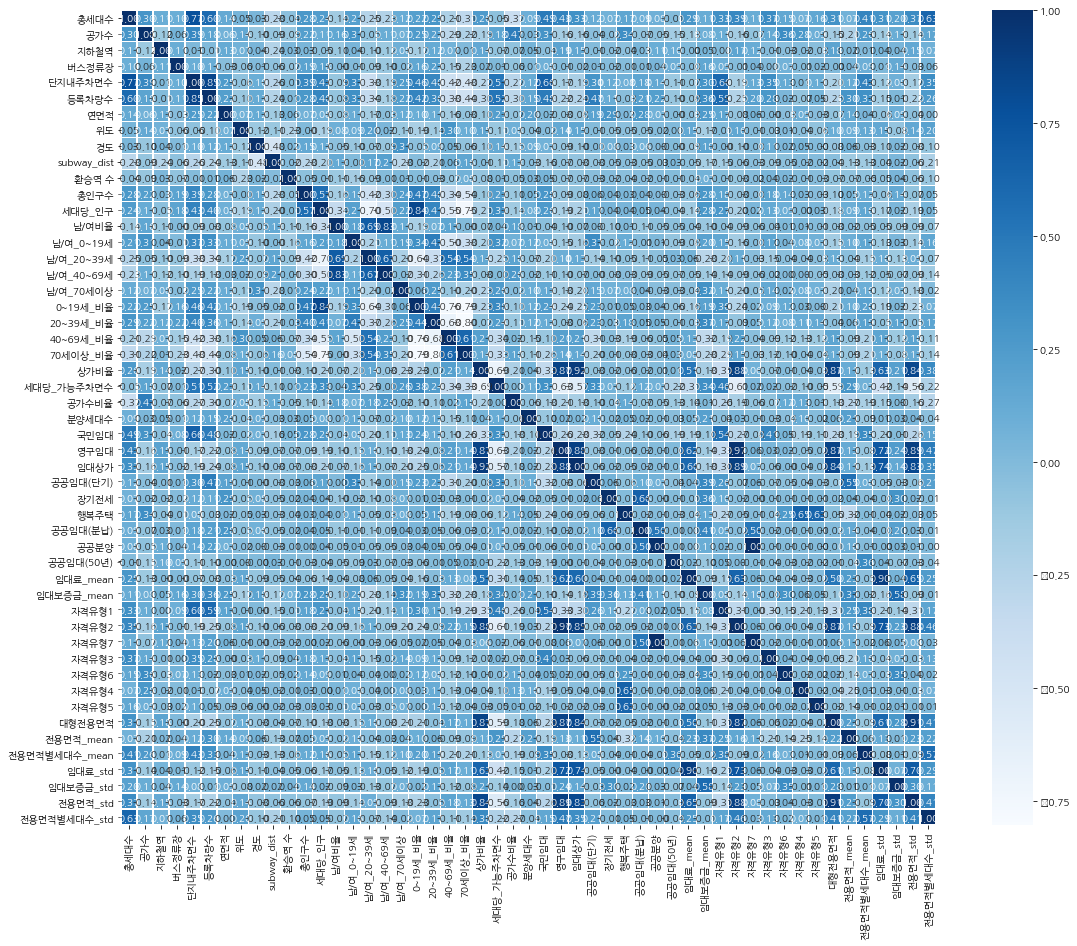

In [62]:
plt.subplots(figsize=(20,15))
sns.heatmap(X_cor.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

### correlation 너무 높은 변수: 
- 영구임대&자격유형2 
- 임대상가&상가비율<br>

# Modeling

In [63]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()

## 기본으로 돌려보기

In [118]:
X = data.drop(columns=['단지명','단지코드','도로명주소','subway_name','등록차량수'])
y = data[['등록차량수']]

In [119]:
X = pd.get_dummies(X, drop_first=True)

In [120]:
len(X.columns)

65

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)

In [85]:
lr= LinearRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_test)
mean_absolute_error(y_test, lr_pred)

132.39385438299013

In [86]:
ri = Ridge().fit(X_train, y_train)
ri_pred = ri.predict(X_test)
mean_absolute_error(y_test, ri_pred)

123.187540946814

In [87]:
la = Lasso().fit(X_train, y_train)
la_pred = la.predict(X_test)
mean_absolute_error(y_test, la_pred)

121.88456404363224

In [88]:
dc = DecisionTreeRegressor(random_state=2021, criterion="mae").fit(X_train, y_train)
dc_pred = dc.predict(X_test)
mean_absolute_error(y_test, dc_pred)

187.368

In [89]:
rf = RandomForestRegressor(random_state=2021, criterion="mae").fit(X_train, y_train)
rf_pred = rf.predict(X_test)
mean_absolute_error(y_test, rf_pred)

116.71236

In [122]:
cb = CatBoostRegressor(random_state=2021).fit(X_train, y_train)
cb_pred = cb.predict(X_test)
mean_absolute_error(y_test, cb_pred)

Learning rate set to 0.031293
0:	learn: 413.6243551	total: 14.5ms	remaining: 14.5s
1:	learn: 407.4757150	total: 26.1ms	remaining: 13s
2:	learn: 401.5790469	total: 35.5ms	remaining: 11.8s
3:	learn: 395.3176474	total: 41.6ms	remaining: 10.3s
4:	learn: 388.7356387	total: 48.7ms	remaining: 9.69s
5:	learn: 383.3053429	total: 57.2ms	remaining: 9.47s
6:	learn: 378.4073077	total: 63.7ms	remaining: 9.03s
7:	learn: 373.0533440	total: 72.9ms	remaining: 9.03s
8:	learn: 367.4404003	total: 79.2ms	remaining: 8.72s
9:	learn: 362.6049832	total: 85.3ms	remaining: 8.44s
10:	learn: 357.0736868	total: 101ms	remaining: 9.08s
11:	learn: 352.7814329	total: 114ms	remaining: 9.39s
12:	learn: 347.7867697	total: 127ms	remaining: 9.67s
13:	learn: 342.5635504	total: 134ms	remaining: 9.41s
14:	learn: 337.9036726	total: 140ms	remaining: 9.2s
15:	learn: 333.1415208	total: 169ms	remaining: 10.4s
16:	learn: 328.2345123	total: 176ms	remaining: 10.2s
17:	learn: 323.5358825	total: 182ms	remaining: 9.94s
18:	learn: 319.4999

114.79750149698461

In [91]:
xgb = XGBRegressor(random_state=2021).fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
mean_absolute_error(y_test, xgb_pred)

120.91358486938476

In [92]:
en=ElasticNet(random_state=2021).fit(X_train, y_train)
en_pred = en.predict(X_test)
mean_absolute_error(y_test, en_pred)

121.64447805213322

Text(0.5, 0, 'CatBoost Feature Importance')

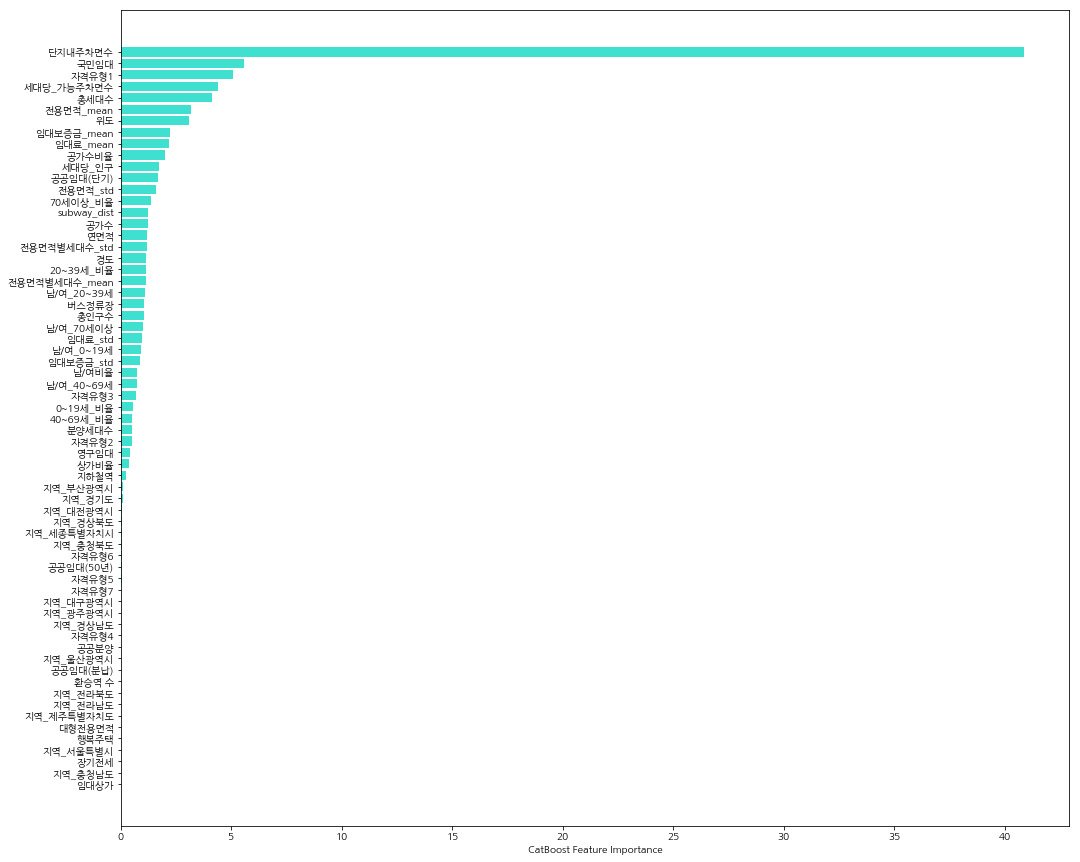

In [123]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = cb.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_feature_importance], 
        cb.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

## 나눠서 modeling

In [78]:
data.단지내주차면수.describe()

count     414.000000
mean      586.330918
std       363.665625
min        13.000000
25%       318.250000
50%       517.000000
75%       785.750000
max      1798.000000
Name: 단지내주차면수, dtype: float64

In [79]:
dat.단지내주차면수.describe()

count     147.000000
mean      558.387755
std       321.009953
min        29.000000
25%       313.000000
50%       499.000000
75%       726.000000
max      1696.000000
Name: 단지내주차면수, dtype: float64

In [93]:
train1=data[data.단지내주차면수<785]
train2=data[data.단지내주차면수>=785]
test1=dat[dat.단지내주차면수<785]
test2=dat[dat.단지내주차면수>=785]

In [94]:
print(train1.shape, train2.shape)
print(test1.shape, test2.shape)

(310, 56) (104, 56)
(113, 53) (34, 53)


In [109]:
X = train2.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', "임대상가", "자격유형2"])
y = train2[['등록차량수']]
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)

In [110]:
#standardScaler.fit(X_train)
#X_train = standardScaler.transform(X_train)
#standardScaler.fit(X_test)
#X_test = standardScaler.transform(X_test)

In [111]:
lr= LinearRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_test)
mean_absolute_error(y_test, lr_pred)

452.9099937300051

In [112]:
ri = Ridge().fit(X_train, y_train)
ri_pred = ri.predict(X_test)
mean_absolute_error(y_test, ri_pred)

304.130339160719

In [113]:
la = Lasso().fit(X_train, y_train)
la_pred = la.predict(X_test)
mean_absolute_error(y_test, la_pred)

354.7558630732611

In [114]:
rf = RandomForestRegressor(criterion="mae",random_state=2021).fit(X_train, y_train)
rf_pred = rf.predict(X_test)
mean_absolute_error(y_test, rf_pred)

279.3175

In [115]:
cb = CatBoostRegressor(random_state=2021).fit(X_train, y_train)
cb_pred = cb.predict(X_test)
mean_absolute_error(y_test, cb_pred)

Learning rate set to 0.024435
0:	learn: 390.4531011	total: 3.8ms	remaining: 3.79s
1:	learn: 388.7462655	total: 5.55ms	remaining: 2.77s
2:	learn: 386.1953126	total: 9.13ms	remaining: 3.04s
3:	learn: 383.2116512	total: 11.6ms	remaining: 2.89s
4:	learn: 380.4098349	total: 14.7ms	remaining: 2.93s
5:	learn: 377.8501028	total: 17.2ms	remaining: 2.85s
6:	learn: 375.6770665	total: 20ms	remaining: 2.83s
7:	learn: 373.1007969	total: 25.9ms	remaining: 3.21s
8:	learn: 371.6930718	total: 28.3ms	remaining: 3.12s
9:	learn: 368.8451137	total: 30.8ms	remaining: 3.05s
10:	learn: 366.0265362	total: 34.3ms	remaining: 3.08s
11:	learn: 362.6781031	total: 37.7ms	remaining: 3.1s
12:	learn: 360.6693747	total: 51.4ms	remaining: 3.9s
13:	learn: 357.4889742	total: 53.9ms	remaining: 3.8s
14:	learn: 355.3562416	total: 60ms	remaining: 3.94s
15:	learn: 352.7602299	total: 63.8ms	remaining: 3.93s
16:	learn: 350.7359670	total: 67.3ms	remaining: 3.89s
17:	learn: 349.3608507	total: 71.4ms	remaining: 3.9s
18:	learn: 347.01

278.7723690625834

In [116]:
xgb = XGBRegressor(random_state=2021).fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
mean_absolute_error(y_test, xgb_pred)

285.68525314331055

In [117]:
en=ElasticNet(random_state=2021).fit(X_train, y_train)
en_pred = en.predict(X_test)
mean_absolute_error(y_test, en_pred)

283.62570902043706

- test1은 catboost, test2는 elastticnet으로 해보자.

# 나눠서 예측

In [91]:
sample=pd.read_csv('sample_submission.csv')
sample.head()

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0


In [92]:
# sample = sample.loc[~sample.code.isin(['C2335', 'C1327', 'C2675'])]

In [93]:
sample.shape

(150, 2)

In [94]:
train1=data[data.단지내주차면수<785]
train2=data[data.단지내주차면수>=785]
test1=dat[dat.단지내주차면수<785]
test2=dat[dat.단지내주차면수>=785]

In [95]:
print(train1.shape, train2.shape)
print(test1.shape, test2.shape)

(310, 49) (104, 49)
(113, 46) (34, 46)


In [139]:
df= pd.concat([train1, test1])

In [140]:
X = df.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', "임대상가", "자격유형2"])
X = pd.get_dummies(X, drop_first=True)

In [141]:
X.train=X.iloc[0:310, :]
X.test=X.iloc[310:, :]
y_train = train1[['등록차량수']]

In [99]:
#X.test["장기전세"]=0
#X.test["공공분양"]=0

In [142]:
model1=CatBoostRegressor(random_state=2021).fit(X.train, y_train)
model1_pred = model1.predict(X.test)

Learning rate set to 0.031686
0:	learn: 228.6784723	total: 7.58ms	remaining: 7.57s
1:	learn: 224.9410559	total: 14.8ms	remaining: 7.38s
2:	learn: 221.5220889	total: 22ms	remaining: 7.31s
3:	learn: 218.4594070	total: 28.3ms	remaining: 7.04s
4:	learn: 215.0869133	total: 34.2ms	remaining: 6.8s
5:	learn: 211.8569750	total: 39.6ms	remaining: 6.56s
6:	learn: 209.0098352	total: 45ms	remaining: 6.39s
7:	learn: 205.8178145	total: 62.1ms	remaining: 7.69s
8:	learn: 202.6829496	total: 69.2ms	remaining: 7.62s
9:	learn: 199.7430417	total: 75.8ms	remaining: 7.51s
10:	learn: 197.2834079	total: 81.3ms	remaining: 7.31s
11:	learn: 195.0637185	total: 89ms	remaining: 7.33s
12:	learn: 192.4903782	total: 95.7ms	remaining: 7.26s
13:	learn: 190.2921679	total: 102ms	remaining: 7.2s
14:	learn: 187.4881788	total: 108ms	remaining: 7.07s
15:	learn: 184.9043639	total: 118ms	remaining: 7.23s
16:	learn: 182.5139188	total: 123ms	remaining: 7.11s
17:	learn: 180.3777748	total: 128ms	remaining: 6.99s
18:	learn: 178.409593

In [101]:
model1=pd.DataFrame(model1_pred)
code1=test1.단지코드
model1=model1.reset_index(drop=True)
code1=code1.reset_index(drop=True)

In [102]:
pred1=pd.concat([code1, model1], axis=1, ignore_index=True)
pred1.columns=["code", "num"]
#pred1=pred1.num.groupby(pred1.code).mean()
pred1.head()

,code,num
0,C1072,682.597167
1,C1456,530.171672
2,C1840,528.142639
3,C1640,429.646043
4,C1377,377.361676


In [147]:
df= pd.concat([train2, test2])

In [148]:
X = df.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', "임대상가", "자격유형2"])
X = pd.get_dummies(X, drop_first=True)

In [149]:
X.train=X.iloc[0:104, :]
X.test=X.iloc[104:, :]
y_train = train2[['등록차량수']]

In [106]:
#X.test["장기전세"]=0
#X.test["공공분양"]=0

In [150]:
model2=CatBoostRegressor(random_state=2021).fit(X.train, y_train)
model2_pred = model2.predict(X.test)

Learning rate set to 0.026088
0:	learn: 399.9708637	total: 2.98ms	remaining: 2.98s
1:	learn: 396.3882864	total: 6.73ms	remaining: 3.36s
2:	learn: 393.2371193	total: 10.8ms	remaining: 3.58s
3:	learn: 390.5436204	total: 14.4ms	remaining: 3.59s
4:	learn: 387.4014219	total: 17.2ms	remaining: 3.43s
5:	learn: 384.4385948	total: 20ms	remaining: 3.31s
6:	learn: 381.8550805	total: 24.6ms	remaining: 3.49s
7:	learn: 378.9612670	total: 28.3ms	remaining: 3.51s
8:	learn: 376.1412375	total: 32.4ms	remaining: 3.56s
9:	learn: 373.8430628	total: 36.3ms	remaining: 3.59s
10:	learn: 371.0021421	total: 39.5ms	remaining: 3.55s
11:	learn: 368.4654637	total: 42.2ms	remaining: 3.47s
12:	learn: 365.5067282	total: 45.1ms	remaining: 3.42s
13:	learn: 362.7970995	total: 47.8ms	remaining: 3.37s
14:	learn: 360.6312789	total: 62.1ms	remaining: 4.08s
15:	learn: 358.1184999	total: 64.8ms	remaining: 3.99s
16:	learn: 355.4474805	total: 77.3ms	remaining: 4.47s
17:	learn: 352.6243442	total: 81.8ms	remaining: 4.46s
18:	learn:

In [108]:
model2=pd.DataFrame(model2_pred)
code2=test2.단지코드
model2=model2.reset_index(drop=True)
code2=code2.reset_index(drop=True)

In [109]:
pred2=pd.concat([code2, model2], axis=1, ignore_index=True)
pred2.columns=["code", "num"]
#pred2=pred2.num.groupby(pred2.code).mean()
pred2.head()

,code,num
0,C1128,1171.794302
1,C1332,1119.500448
2,C1563,1639.988185
3,C1794,937.756404
4,C2411,778.158678


In [110]:
df_merge=pd.DataFrame(pd.concat([pred1, pred2], axis=0))
df_merge=df_merge.reset_index(drop=True)

In [111]:
df_merge.head()

,code,num
0,C1072,682.597167
1,C1456,530.171672
2,C1840,528.142639
3,C1640,429.646043
4,C1377,377.361676


In [112]:
test_split=pd.merge(sample, df_merge, on='code', how='outer')

In [113]:
test_split.head()

,code,num_x,num_y
0,C1072,0,682.597167
1,C1128,0,1171.794302
2,C1456,0,530.171672
3,C1840,0,528.142639
4,C1332,0,1119.500448


In [114]:
test_split= test_split.drop(columns='num_x')
test_split.columns=["code","num"]

In [115]:
test_split[test_split.num<=0].index

Int64Index([], dtype='int64')

In [116]:
#pip install shap
import shap

In [117]:
from catboost import Pool

In [143]:
sorted_feature_importance = model1.feature_importances_.argsort()

In [144]:
sorted_feature_importance

array([53, 49, 39, 30, 29, 48, 52, 27, 54, 55, 50, 51, 45, 46, 40, 37, 21,
       31, 38, 47,  9, 36, 28, 41, 42, 44, 43, 35,  2, 12,  8, 20, 11, 25,
       10, 17, 26, 13, 19, 14,  1,  3,  7, 15, 18,  5, 16, 32,  6,  0, 23,
       33, 22, 24, 34,  4], dtype=int64)

In [145]:
X.test.columns[sorted_feature_importance]
# train1

Index(['지역_제주특별자치도', '지역_세종특별자치시', '자격유형5', '공공분양', '공공임대(분납)', '지역_서울특별시',
       '지역_전라북도', '장기전세', '지역_충청남도', '지역_충청북도', '지역_울산광역시', '지역_전라남도',
       '지역_대구광역시', '지역_대전광역시', '대형전용면적', '자격유형6', '상가비율', '공공임대(50년)', '자격유형4',
       '지역_부산광역시', '환승역 수', '자격유형3', '행복주택', '지역_경기도', '지역_경상남도', '지역_광주광역시',
       '지역_경상북도', '자격유형7', '지하철역', '남/여비율', 'subway_dist', '70세이상_비율',
       '세대당_인구', '영구임대', '총인구수', '0~19세_비율', '공공임대(단기)', '남/여_0~19세',
       '40~69세_비율', '남/여_20~39세', '공가수', '버스정류장', '경도', '남/여_40~69세',
       '20~39세_비율', '연면적', '남/여_70세이상', '임대료', '위도', '총세대수', '공가수비율', '임대보증금',
       '세대당_가능주차면수', '국민임대', '자격유형1', '단지내주차면수'],
      dtype='object')

Text(0.5, 0, 'CatBoost Feature Importance')

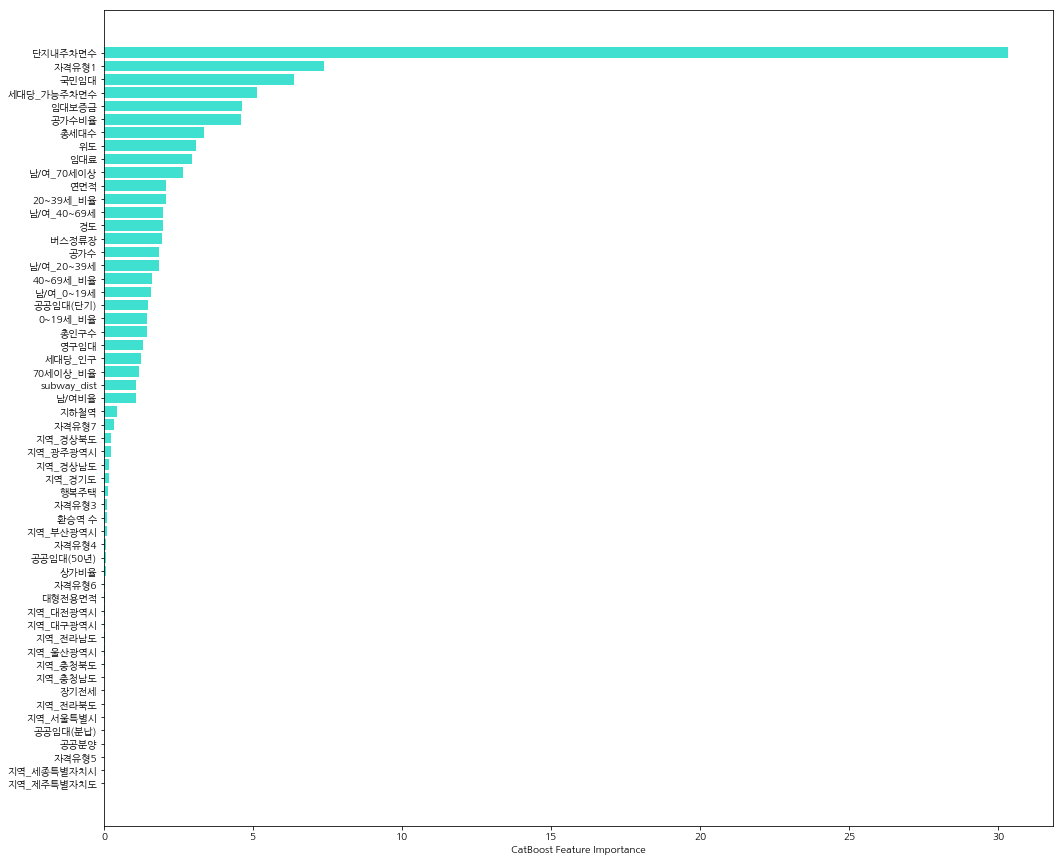

In [146]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model1.feature_importances_.argsort()
plt.barh(X.test.columns[sorted_feature_importance], 
        model1.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [151]:
sorted_feature_importance = model2.feature_importances_.argsort()
sorted_feature_importance

array([21, 31, 51, 40, 48, 27, 50, 52, 39,  9, 47, 41, 37, 29, 45, 43, 35,
       46, 54, 38, 30, 44, 42, 25, 53,  2, 49, 28, 11, 16, 13, 12, 15, 18,
        7, 17, 36, 20,  8, 10, 14,  5,  1,  3, 22,  6, 19, 34, 24,  0, 33,
       23, 26, 32,  4], dtype=int64)

In [152]:
X.test.columns[sorted_feature_importance]
# train2

Index(['상가비율', '공공임대(50년)', '지역_전라북도', '대형전용면적', '지역_서울특별시', '장기전세', '지역_전라남도',
       '지역_제주특별자치도', '자격유형5', '환승역 수', '지역_부산광역시', '지역_경기도', '자격유형6',
       '공공임대(분납)', '지역_대구광역시', '지역_경상북도', '자격유형7', '지역_대전광역시', '지역_충청북도',
       '자격유형4', '공공분양', '지역_광주광역시', '지역_경상남도', '영구임대', '지역_충청남도', '지하철역',
       '지역_세종특별자치시', '행복주택', '세대당_인구', '남/여_70세이상', '남/여_0~19세', '남/여비율',
       '남/여_40~69세', '20~39세_비율', '경도', '0~19세_비율', '자격유형3', '70세이상_비율',
       'subway_dist', '총인구수', '남/여_20~39세', '연면적', '공가수', '버스정류장',
       '세대당_가능주차면수', '위도', '40~69세_비율', '자격유형1', '국민임대', '총세대수', '임대보증금',
       '공가수비율', '공공임대(단기)', '임대료', '단지내주차면수'],
      dtype='object')

Text(0.5, 0, 'CatBoost Feature Importance')

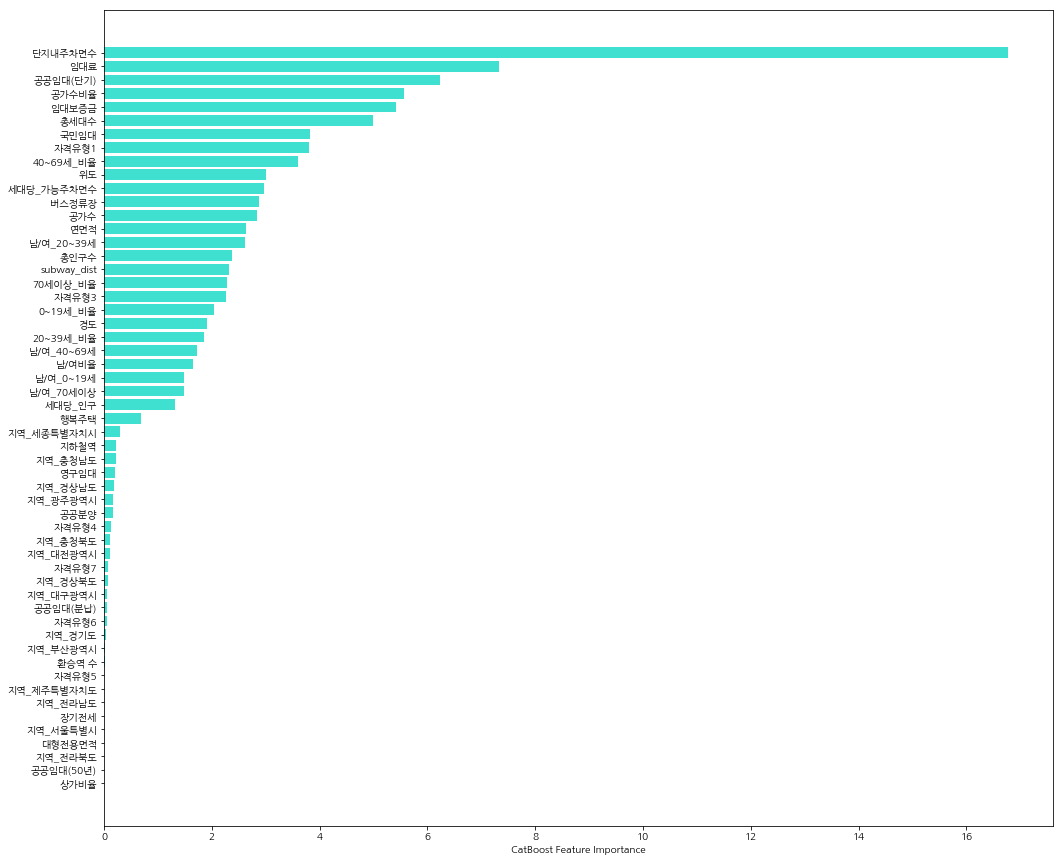

In [153]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model2.feature_importances_.argsort()
plt.barh(X.test.columns[sorted_feature_importance], 
        model2.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [ ]:
#test_split.to_csv('0713_cb.csv', index=False)